# Predicting alzheimer disease from CT images

Practicing deep learning skills

A practice project from https://github.com/World-of-ML/DL-Simplified

UTK face dataset from https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

## Preprocess data

In [1]:
# Get the class names programmatically 
import pathlib 
import numpy as np

data_dir = pathlib.Path('./Alzheimer_s Dataset/train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [2]:
# visualize our image 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 
import os

def view_random_image(target_dir, target_class):
  # Setup the target directory (well view images from here)
  target_folder = target_dir+target_class
  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder), 1) #randomly get a image from the folder 
  print(random_image)

  #read in the image and plot it 
  img = mpimg.imread(target_folder + '/'+ random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}') # show the shape of the image 

  return img

['mildDem365.jpg']
Image shape: (208, 176)


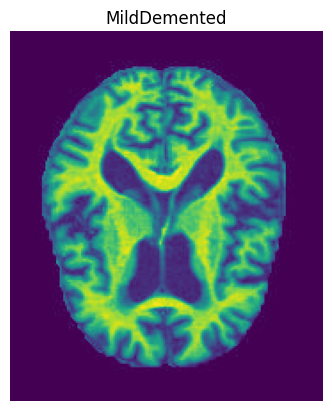

In [3]:
# View a image from the training dataset 
img = view_random_image(target_dir= './Alzheimer_s Dataset/train/',
                        target_class='MildDemented')

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(512)

# normalize our data
train_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = './Alzheimer_s Dataset/train/'
test_dir = './Alzheimer_s Dataset/test/'

train_data = train_datagen.flow_from_directory(train_dir,
                                              batch_size = 32, 
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              seed=512,
                                              subset="training")

val_data = train_datagen.flow_from_directory(train_dir,
                                              batch_size = 32, 
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              seed=512,
                                              subset="validation")

test_data = test_datagen.flow_from_directory(test_dir,
                                            batch_size=32,
                                            target_size=(224, 224),
                                            class_mode='categorical')

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Modeling experiment: 

Since we have a very small amount of data, we will run through experiments with a Baseline (convolutional 2D) model and adapt transfer learning. 

### Model 1: Baseline

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model_1 = Sequential([
                        Conv2D(filters=64,
                                kernel_size=3,
                                activation='relu',
                                input_shape=(224,224,3)),
                        Conv2D(64,3,activation='relu'),
                        MaxPool2D(pool_size=2,
                                  padding='valid'),
                        Conv2D(128, 3, activation='relu'),
                        Conv2D(256, 3, activation='relu'),
                        MaxPool2D(2),
                        Flatten(),
                        Dense(4, activation='softmax')])

model_1.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

history = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/10
145/145 [==============================] - 60s 246ms/step - loss: 1.0427 - accuracy: 0.5067 - val_loss: 1.0003 - val_accuracy: 0.5245
Epoch 2/10
145/145 [==============================] - 26s 179ms/step - loss: 0.8897 - accuracy: 0.5946 - val_loss: 1.0955 - val_accuracy: 0.4853
Epoch 3/10
145/145 [==============================] - 24s 166ms/step - loss: 0.6954 - accuracy: 0.6863 - val_loss: 0.8590 - val_accuracy: 0.6125
Epoch 4/10
145/145 [==============================] - 25s 174ms/step - loss: 0.2879 - accuracy: 0.8887 - val_loss: 0.5279 - val_accuracy: 0.7632
Epoch 5/10
145/145 [==============================] - 24s 166ms/step - loss: 0.0827 - accuracy: 0.9707 - val_loss: 0.1997 - val_accuracy: 0.9217
Epoch 6/10
145/145 [==============================] - 24s 166ms/step - loss: 0.0302 - accuracy: 0.9885 - val_loss: 0.2229 - val_accuracy: 0.9159
Epoch 7/10
145/145 [==============================] - 24s 166ms/step - loss: 0.0257 - accuracy: 0.9907 - val_loss: 0.1641 - val_ac

In [6]:
model_1.evaluate(test_data)

40/40 [==============================] - 8s 207ms/step - loss: 2.9574 - accuracy: 0.5708


[2.9574429988861084, 0.5707584023475647]

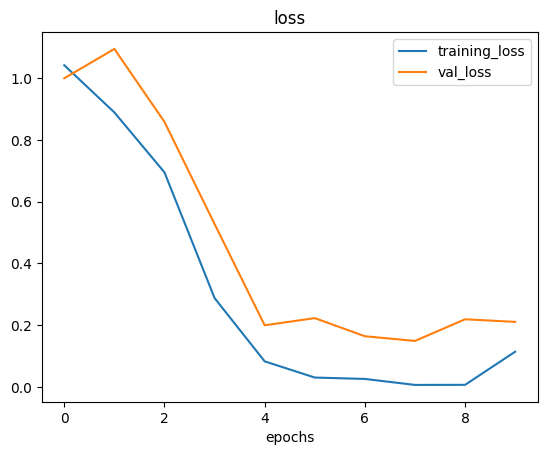

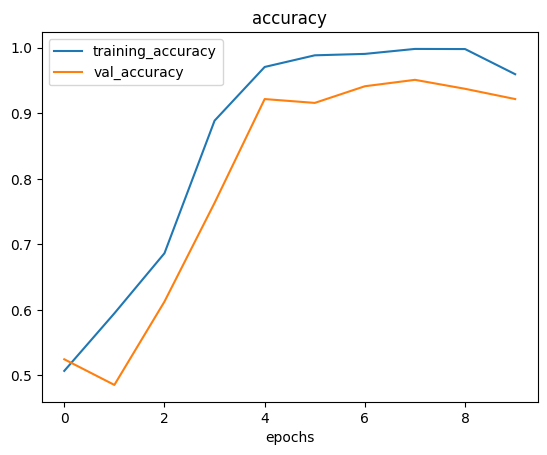

In [7]:
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics. 
  '''

  loss=history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss'])) # how many epochs we run 

  #plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss'),
  plt.xlabel('epochs')
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy'),
  plt.xlabel('epochs')
  plt.legend()

plot_loss_curves(history)

### Model 2: VGG 19

In [8]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.layers import GlobalAveragePooling2D
vgg19 = vgg19.VGG19(include_top=False,
                    weights='imagenet',
                    input_shape=(224, 224, 3)
                    )

vgg19.trainable = True 

# Freeze all layers expect for the last 10 
for layer in vgg19.layers[:-10]:
    layer.trainable = False


model_2 = Sequential([
                vgg19,
                GlobalAveragePooling2D(),
                Dense(4, activation='softmax')
                
])

model_2.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/10
145/145 [==============================] - 46s 270ms/step - loss: 0.9361 - accuracy: 0.5360 - val_loss: 0.8452 - val_accuracy: 0.5969
Epoch 2/10
145/145 [==============================] - 33s 227ms/step - loss: 0.8163 - accuracy: 0.6130 - val_loss: 0.8520 - val_accuracy: 0.5851
Epoch 3/10
145/145 [==============================] - 34s 232ms/step - loss: 0.6515 - accuracy: 0.7189 - val_loss: 0.7419 - val_accuracy: 0.6634
Epoch 4/10
145/145 [==============================] - 33s 226ms/step - loss: 0.4496 - accuracy: 0.8184 - val_loss: 0.4390 - val_accuracy: 0.7965
Epoch 5/10
145/145 [==============================] - 27s 188ms/step - loss: 0.2069 - accuracy: 0.9219 - val_loss: 0.1986 - val_accuracy: 0.9119
Epoch 6/10
145/145 [==============================] - 29s 197ms/step - loss: 0.1371 - accuracy: 0.9510 - val_loss: 0.2291 - val_accuracy: 0.9256
Epoch 7/10
145/145 [==============================] - 29s 200ms/step - loss: 0.0756 - accuracy: 0.9731 - val_loss: 0.2148 - val_ac

In [9]:
model_2.evaluate(test_data)

40/40 [==============================] - 3s 82ms/step - loss: 1.2097 - accuracy: 0.6865


[1.2096620798110962, 0.6864737868309021]

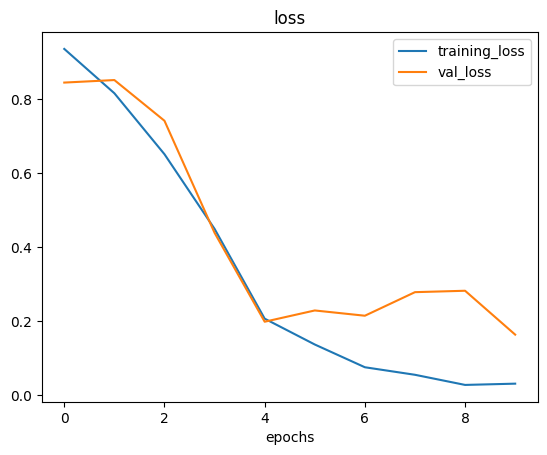

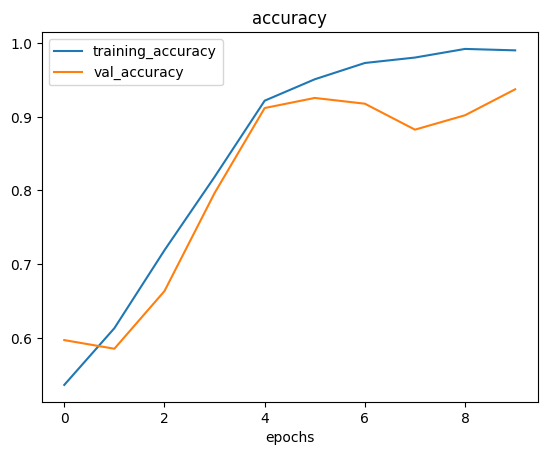

In [10]:
plot_loss_curves(history_2)

### Model 3: ResNet

In [11]:
from tensorflow.keras.applications import resnet_v2
resnet = resnet_v2.ResNet101V2(include_top=False,
                                weights='imagenet',
                                input_shape=(224, 224, 3)
                                )

resnet.trainable = True 

# Freeze all layers expect for the last 10 
for layer in resnet.layers[:-10]:
    layer.trainable = False


model_3 = Sequential([
                resnet,
                GlobalAveragePooling2D(),
                Dense(4, activation='softmax')
                
])

model_3.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy'])

history_3 = model_3.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/10
145/145 [==============================] - 19s 98ms/step - loss: 0.7885 - accuracy: 0.6540 - val_loss: 0.8453 - val_accuracy: 0.6321
Epoch 2/10
145/145 [==============================] - 13s 92ms/step - loss: 0.3771 - accuracy: 0.8818 - val_loss: 0.8410 - val_accuracy: 0.6164
Epoch 3/10
145/145 [==============================] - 13s 92ms/step - loss: 0.1622 - accuracy: 0.9685 - val_loss: 0.4997 - val_accuracy: 0.7886
Epoch 4/10
145/145 [==============================] - 13s 93ms/step - loss: 0.0640 - accuracy: 0.9935 - val_loss: 0.3837 - val_accuracy: 0.8356
Epoch 5/10
145/145 [==============================] - 14s 94ms/step - loss: 0.0510 - accuracy: 0.9944 - val_loss: 0.4045 - val_accuracy: 0.8454
Epoch 6/10
145/145 [==============================] - 13s 89ms/step - loss: 0.0213 - accuracy: 0.9996 - val_loss: 0.3114 - val_accuracy: 0.8924
Epoch 7/10
145/145 [==============================] - 13s 93ms/step - loss: 0.0165 - accuracy: 0.9993 - val_loss: 0.3273 - val_accuracy:

In [12]:
model_3.evaluate(test_data)

40/40 [==============================] - 4s 94ms/step - loss: 1.5294 - accuracy: 0.6255


[1.529389500617981, 0.6254886388778687]

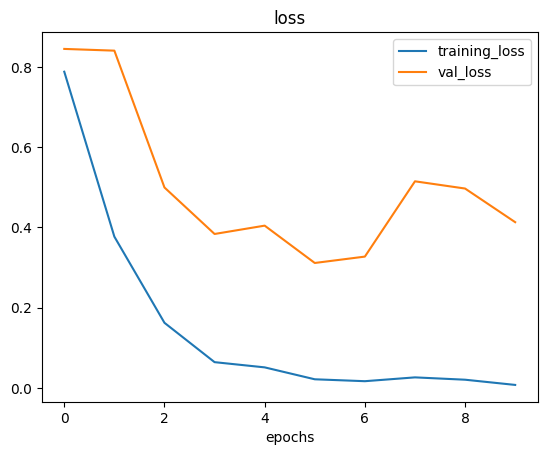

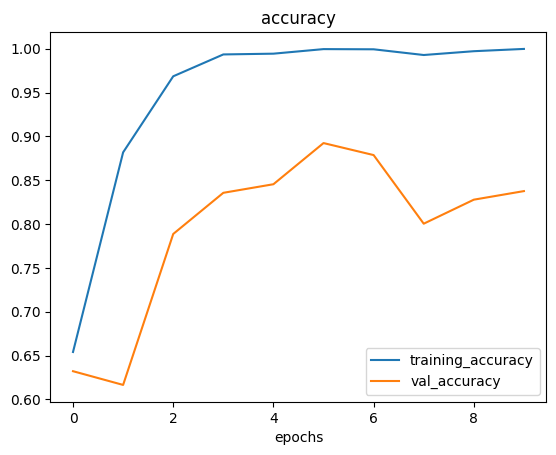

In [13]:
plot_loss_curves(history_3)

### Model 4: Xception

In [14]:
from tensorflow.keras.applications import xception
xception_model = xception.Xception(include_top=False,
                            weights='imagenet',
                            input_shape=(224, 224, 3)
                                )

xception_model.trainable = True 

# Freeze all layers expect for the last 10 
for layer in xception_model.layers[:-10]:
    layer.trainable = False


model_4 = Sequential([
                xception_model,
                GlobalAveragePooling2D(),
                Dense(4, activation='softmax')
                
])

model_4.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy'])

history_4 = model_4.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/10
145/145 [==============================] - 12s 70ms/step - loss: 0.8571 - accuracy: 0.5948 - val_loss: 1.9305 - val_accuracy: 0.5029
Epoch 2/10
145/145 [==============================] - 9s 64ms/step - loss: 0.5860 - accuracy: 0.7547 - val_loss: 0.9214 - val_accuracy: 0.6517
Epoch 3/10
145/145 [==============================] - 9s 63ms/step - loss: 0.3833 - accuracy: 0.8681 - val_loss: 0.8195 - val_accuracy: 0.6595
Epoch 4/10
145/145 [==============================] - 9s 65ms/step - loss: 0.2212 - accuracy: 0.9414 - val_loss: 0.5135 - val_accuracy: 0.7847
Epoch 5/10
145/145 [==============================] - 9s 65ms/step - loss: 0.1303 - accuracy: 0.9738 - val_loss: 0.4567 - val_accuracy: 0.8082
Epoch 6/10
145/145 [==============================] - 9s 64ms/step - loss: 0.0755 - accuracy: 0.9887 - val_loss: 0.4584 - val_accuracy: 0.8317
Epoch 7/10
145/145 [==============================] - 9s 64ms/step - loss: 0.0748 - accuracy: 0.9852 - val_loss: 0.7760 - val_accuracy: 0.708

In [15]:
model_4.evaluate(test_data)

40/40 [==============================] - 3s 65ms/step - loss: 0.9582 - accuracy: 0.6740


[0.9581733345985413, 0.6739640235900879]

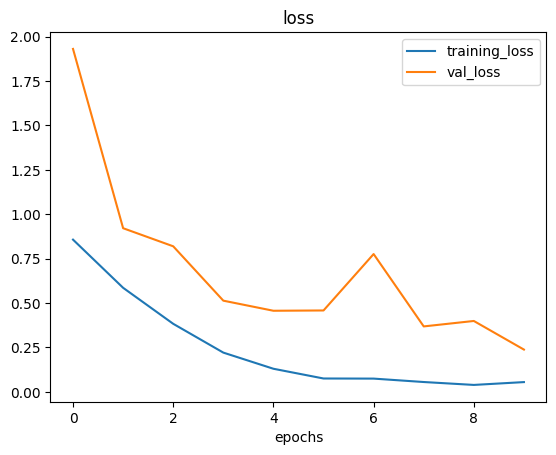

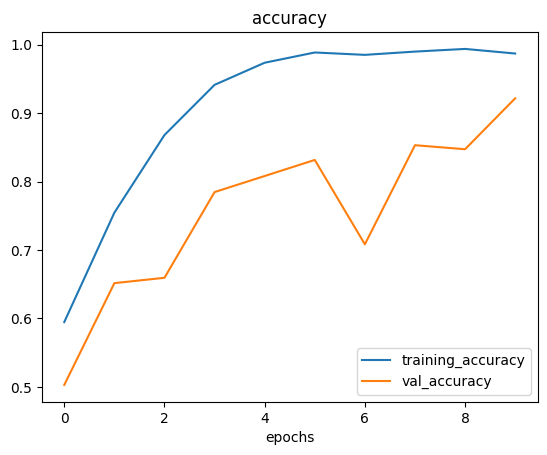

In [16]:
plot_loss_curves(history_4)

## Compare model results

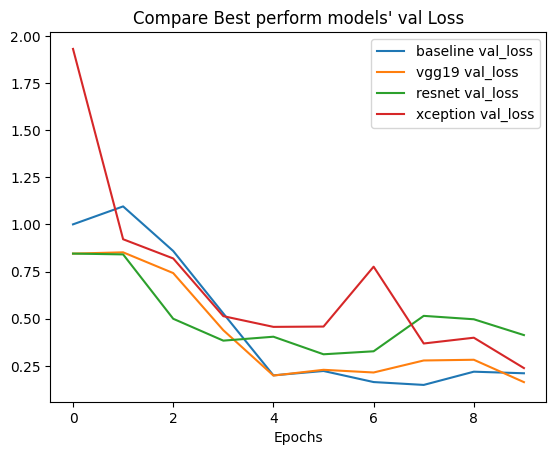

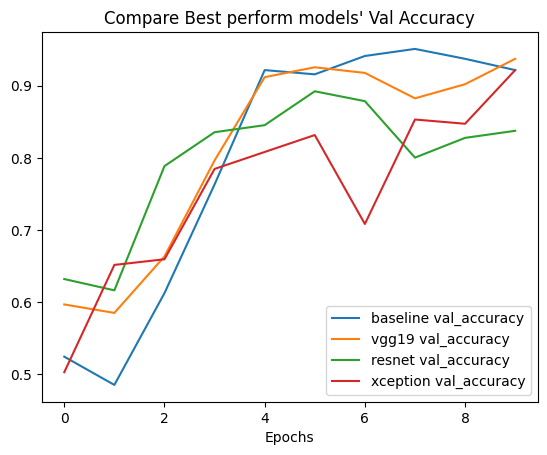

In [17]:
  val_loss = history.history['val_loss']
  val_loss1 = history_2.history['val_loss']
  val_loss2 = history_3.history['val_loss']
  val_loss3 = history_4.history['val_loss']
    
  val_accuracy = history.history['val_accuracy']
  val_accuracy1 = history_2.history['val_accuracy']
  val_accuracy2 = history_3.history['val_accuracy']
  val_accuracy3 = history_4.history['val_accuracy']
    
  epochs = range(len(history.history['loss']))
  epochs1 = range(len(history_2.history['loss']))
  epochs2 = range(len(history_3.history['loss']))
  epochs3 = range(len(history_4.history['loss']))


  # Plot loss
  plt.plot(epochs, val_loss, label='baseline val_loss')
  plt.plot(epochs1, val_loss1, label='vgg19 val_loss')
  plt.plot(epochs2, val_loss2, label='resnet val_loss')
  plt.plot(epochs3, val_loss3, label='xception val_loss')  
  plt.title("Compare Best perform models' val Loss")
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, val_accuracy, label='baseline val_accuracy')
  plt.plot(epochs1, val_accuracy1, label='vgg19 val_accuracy')
  plt.plot(epochs2, val_accuracy2, label='resnet val_accuracy')
  plt.plot(epochs3, val_accuracy3, label='xception val_accuracy')
  plt.title("Compare Best perform models' Val Accuracy")
  plt.xlabel('Epochs')
  plt.legend();

## Plot random images and make predictions

In [18]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  img = np.repeat(img, 3, axis=-1)
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

(224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(224, 224, 3)
1/1 [==============================] - 0s 16ms/step


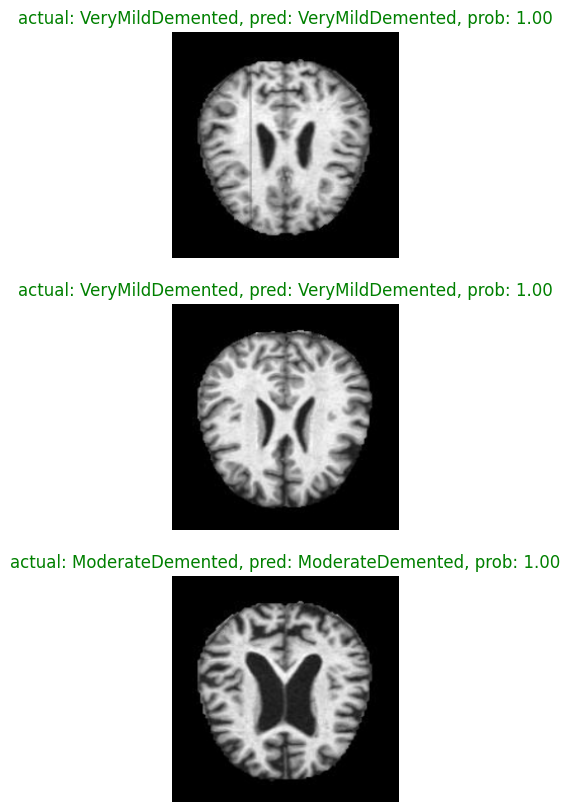

In [20]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + '/' + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  print(img.shape)
  pred_prob = model_2.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 1, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);